# GEOG 5160 6160 Lab 03

In this lab, we’ll look at how to implement a range of tree methods including basic classification and regression trees, random forests and boosted regression trees. We will also look at how to predict for new data and how to carry out hyperparameter tuning.

We’ll illustrate these methods by using them to build a species distribution model for the pinon pine in the western United States. You will need the following datasets from Canvas, so download these to your datafiles folder (extract any zip files). Make a new folder for today’s class called lab07 and move these files to it (you'll need to unzip one of them):

- Pinus_edulis.csv
- ne_50m_admin_0_countries.zip
- current.env.nc
- future.env.nc

## Objectives

-   Understand how to set use functions to train, test and examine tree-based models
-   Use a validation dataset to tune model hyperparameters
-   Make and visualize predictions


You will need to make sure the following packages are installed on your computer (in addition to the packages we have used in previous labs). 

- **xarray**: functions for working with regular arrays like climate data. You'll need to install a specific version of this (`2024.2.0`) So either `conda install xarray=2024.2.0` or `pip install xarray==2024.2.0`). If you are unsure about this step, please ask me
- **xgboost**: extreme gradient boosting (`conda install py-xgboost`)
- **geopandas**: package for working with geospatial data (`conda install geopandas`)


## Data processing

Let's start by by importing the modules we'll need for the class, then we'll go get the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

np.random.seed(1234)

### Pinus edulis data

Now, let's read in the known locations of *Pinus edulis* trees from the file *Pinus_edulis.csv*, and a set of pseudo-absences from the file *absence.csv*

In [2]:
pe = pd.read_csv("./datafiles/pe_df.csv")
pe.head()

,gbifid,species,latitude,longitude,pa,bio1,bio2,bio3,bio4,bio5,...,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,bio18,bio19
0,1.899817e+09,Pinus edulis,38.866005,-104.896667,1,8.0,16.6,4.2,789.0,28.7,...,18.5,-1.7,427.0,73.0,9.0,60.0,194.0,34.0,194.0,34.0
1,1.899816e+09,Pinus edulis,38.875486,-104.883196,1,6.4,16.7,4.2,778.1,27.0,...,16.7,-3.2,452.0,76.0,10.0,59.0,204.0,38.0,204.0,38.0
2,1.899814e+09,Pinus edulis,38.722775,-104.839340,1,5.8,16.2,4.2,778.0,26.1,...,16.1,-3.8,474.0,81.0,11.0,58.0,214.0,43.0,214.0,43.0
3,1.899814e+09,Pinus edulis,38.864713,-104.897199,1,8.0,16.6,4.2,789.0,28.7,...,18.5,-1.7,427.0,73.0,9.0,60.0,194.0,34.0,194.0,34.0
4,1.899813e+09,Pinus edulis,38.908459,-104.855046,1,8.2,16.4,4.1,792.9,28.9,...,18.8,-1.5,426.0,72.0,9.0,60.0,194.0,34.0,194.0,34.0


We'll also make up an array of feature names for use in plotting:

In [3]:
var_names = ["bio"+str(i+1) for i in range(19)]

Before moving on, we'll convert this new DataFrame to a GeoPandas dataframe, so we can make some quick maps of the presence/absence values and one of the associated environmental variables (`bio7`). 

In [4]:
pe_gpd = gpd.GeoDataFrame(pe, 
                          geometry=gpd.points_from_xy(pe.longitude, pe.latitude), 
                               crs=4326)

<Axes: >

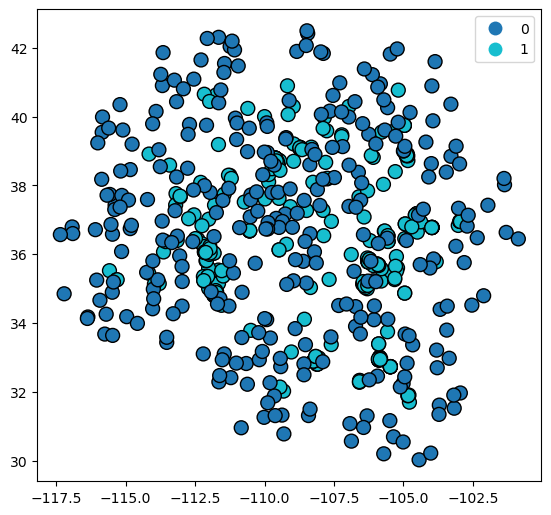

In [5]:
pe_gpd.plot(column="pa", figsize = (6.5, 6.5), categorical=True, 
            markersize = 100, legend=True, edgecolor="black")

<Axes: >

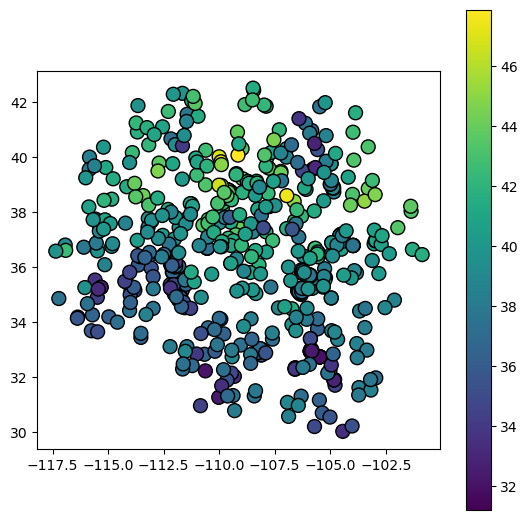

In [6]:
pe_gpd.plot(column="bio7", figsize = (6.5, 6.5), 
            markersize = 100, legend=True, edgecolor="black")

## Classification and regression trees

Classification and Regression Trees (CART) are a non-linear, non-parametric modeling approach that can be used with a wide variety of data. Regression trees are used with continuous outcome data, and classification trees with binary or categorical data, but the interface for these is the same in scikit-learn. We'll build a classification model for the *Pinus edulis* data set. First, let's set up the training and testing set using all 19 of the bioclimatic variables, first dividing into features `X` and target `y`:

In [7]:
feature_names = ["bio"+str(i+1) for i in range(19)]

X = pe[feature_names]
y = pe['pa']

Next we'll split into a training and testing set (80/20 split)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = 0.8)

No prizes for guessing that the scikit-learn function for a classification decision tree is called `DecisionTreeClassifier()`. Let's initialize one of these, and train it on our dataset with default hyperparameters

In [9]:
from sklearn.tree import DecisionTreeClassifier
pe_tree = DecisionTreeClassifier()
pe_tree = pe_tree.fit(X_train, y_train)

Now let's plot the resulting tree

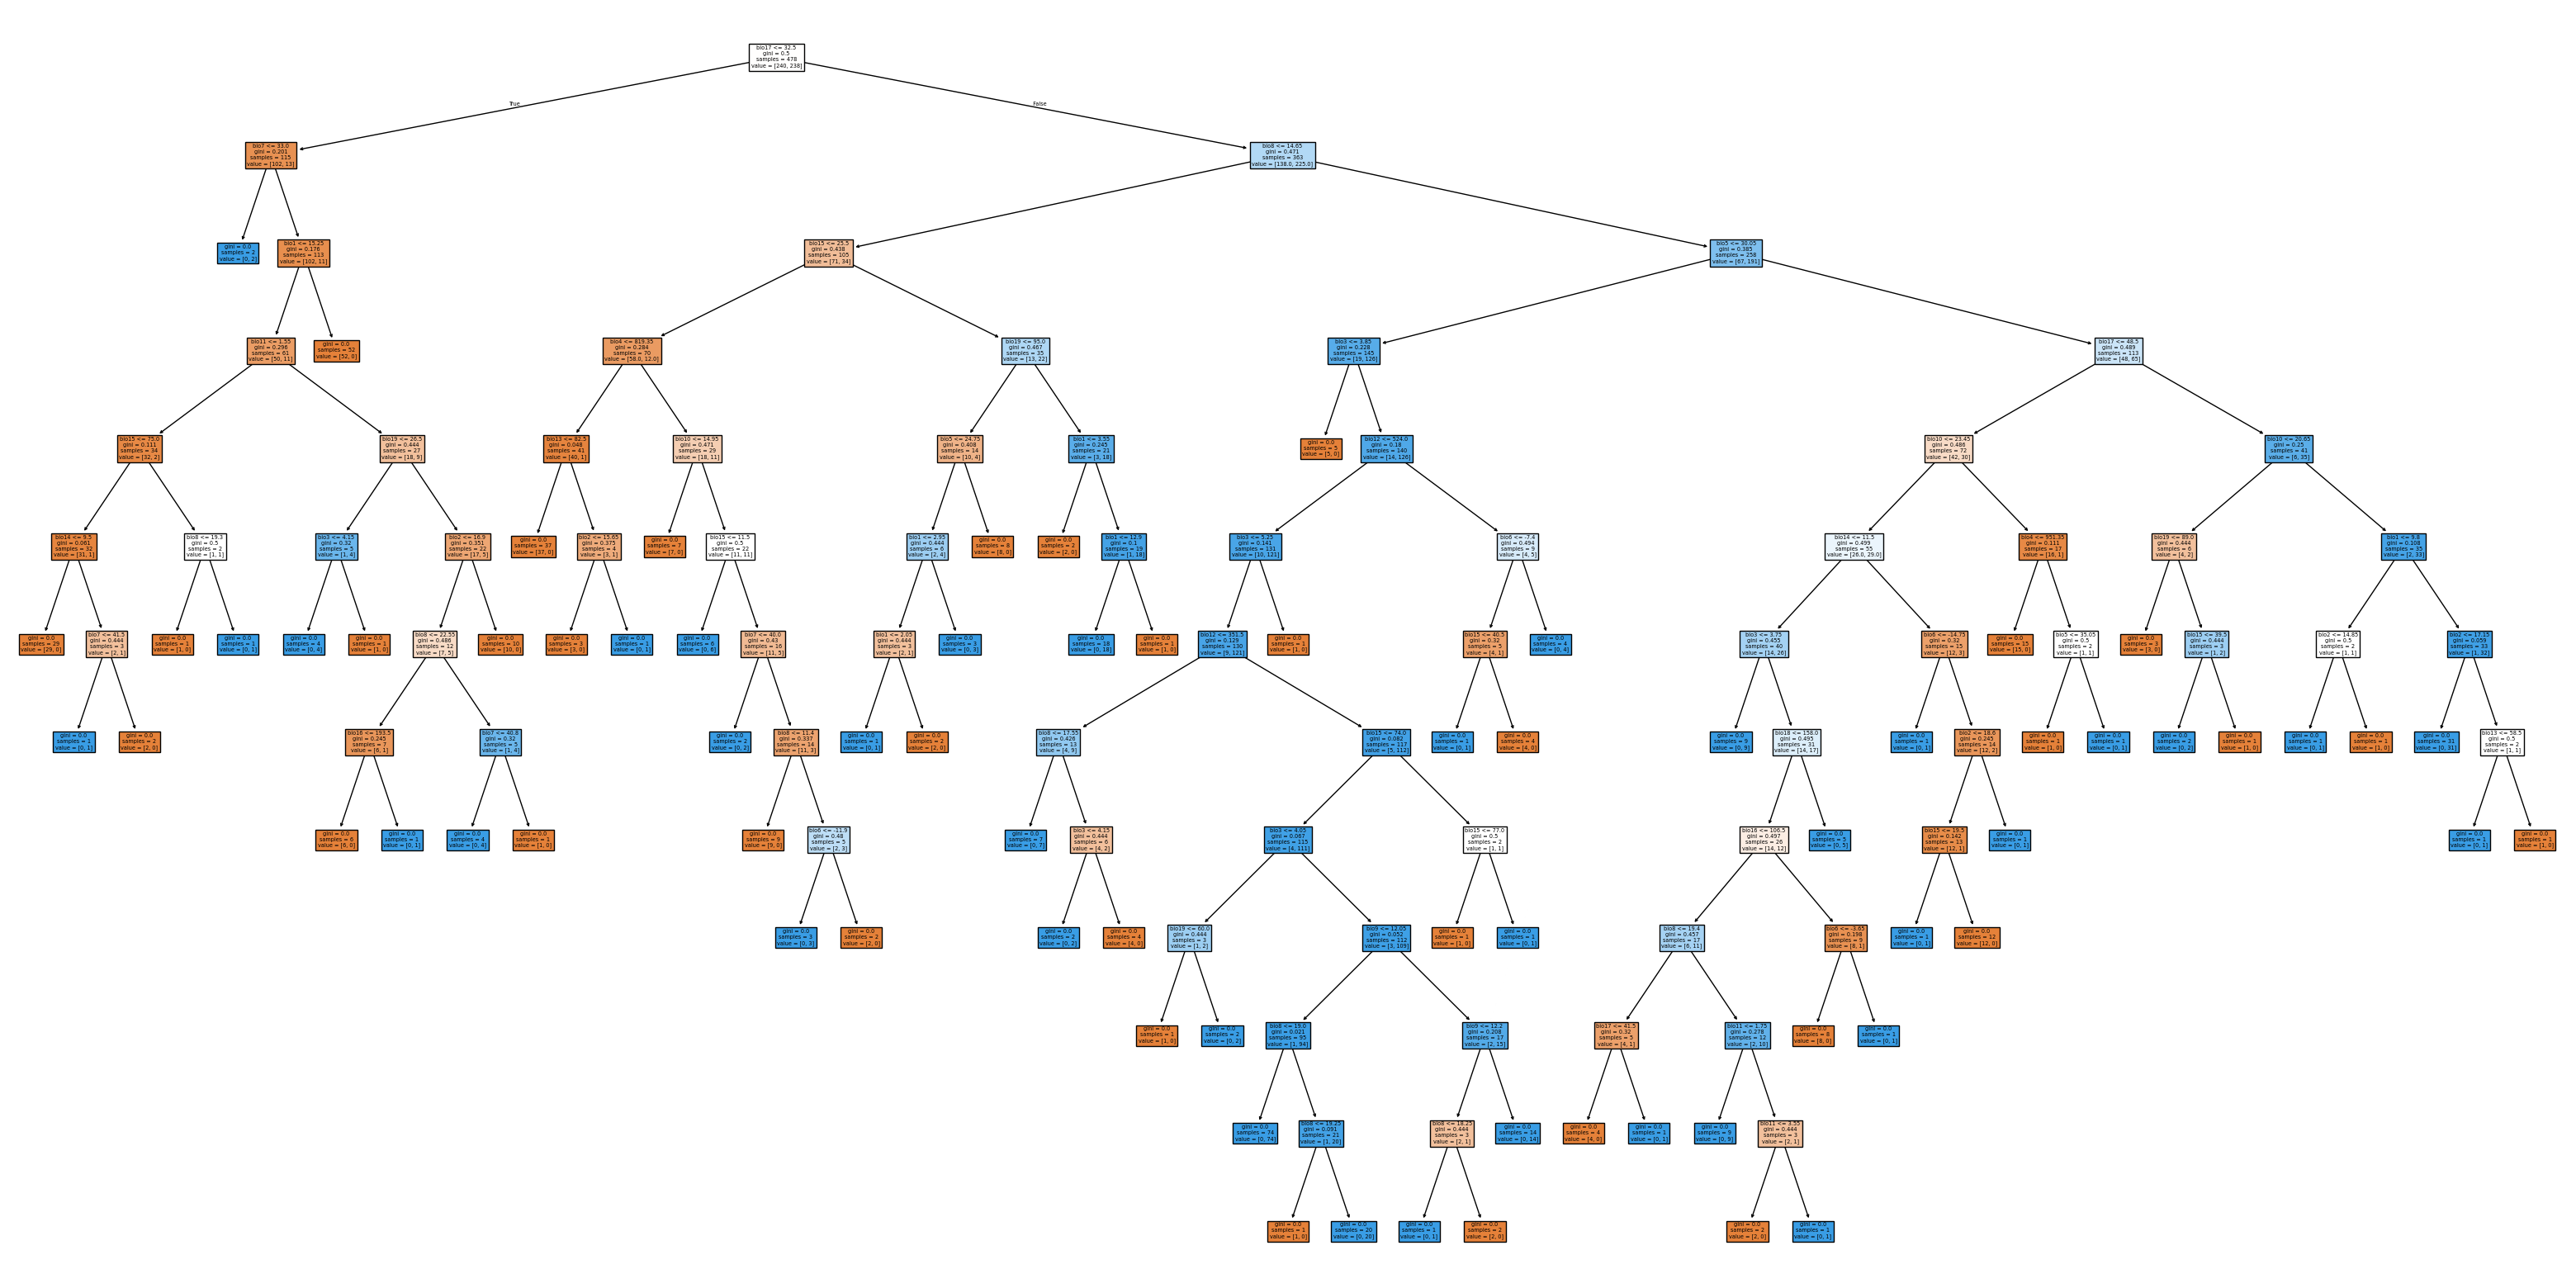

In [10]:
from sklearn.tree import plot_tree

plt.figure(figsize=(40,20)) 
plot_tree(pe_tree, feature_names=feature_names, filled=True)
plt.show()

The default settings result in a very complex and potentiall overfit tree. To illustrate this, let's calculate the accuracy on the testing set:

In [11]:
from sklearn.metrics import accuracy_score
y_test_pred = pe_tree.predict(X_test)
acc = accuracy_score(y_test, y_test_pred)
print(f'Accuracy: {np.round(acc, 4)}')

Accuracy: 0.7833


### Tuning

Let's try to improve on this model by tuning it to find the best set of hyperparameters to limit overfitting. You can get the list of available hyperparameters for any scikit-learn model using `get_params()`

In [12]:
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

There are several here that we could try to tune, but we'll focus on two that are important in limiting tree size:

- `max_depth`: the maximum number of splits along any branch of the tree
- `min_samples_leaf`: the minimum number of samples in a child node for it to be considered in the splitting procedure

We'll use a scikit-learn function to help with the tuning called `GridSearchCV()`. As the name might imply, this will carry out a cross-validated search among a set of hyperparameter values to find the best value. Practically, this takes the dataset, splits it into training and testing, builds several models with different parameter values and predicts for the test set. The best values are then saved and returned. 

After importing the function, we need to define the parameter space that will be searched. This is set up as a Python dictionary, with the name of the hyperparameter as the key, and the value or set of values to be tested. Any parameters that are not specified will be held at their default values. 

In [13]:
from sklearn.model_selection import GridSearchCV
tree_param = {'max_depth':[4,5,6,7,8,9,10],
             'min_samples_leaf':[5,6,7,8,9,10]}

Having done this, we set up the cross-validation strategy using `GridSearchCV()`. We need to specify:

- The algorithm to be tuned (`DecisionTreeClassifier`)
- The parameter space (defined above)
- The performance metric to be used to select the parameter values (`accuracy`)
- The cross-validation strategy. Here we are using a simple 5-fold cross-validation, but it is possible to replace this with more complex strategies

In [14]:
pe_tree_tuned = GridSearchCV(DecisionTreeClassifier(), tree_param, 
                             scoring='accuracy', cv=5)

Now we use the standard scikit-learn `fit()` method to run the tuning

In [15]:
pe_tree_tuned.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [5, 6, 7, 8, 9, 10]},
             scoring='accuracy')

The full set of results are held in `pe_tree_tuned.cv_results_`, but we'll just show here the range of AUC scores found during tuning. These vary a little (between about 0.72 and 0.79). Tuning has a relatively small impact on decision trees, so this small range is not too surprising.

In [16]:
print(pe_tree_tuned.cv_results_['mean_test_score'])

[0.76364035 0.76993421 0.77620614 0.77203947 0.77412281 0.77412281
 0.77208333 0.76574561 0.77833333 0.77622807 0.78458333 0.77620614
 0.75322368 0.76576754 0.78039474 0.76995614 0.78039474 0.7783114
 0.73451754 0.74280702 0.76164474 0.7533114  0.76164474 0.74057018
 0.74486842 0.73850877 0.77412281 0.7741886  0.77201754 0.76572368
 0.72190789 0.73640351 0.77412281 0.76995614 0.77616228 0.76780702
 0.72813596 0.7427193  0.7720614  0.77210526 0.7825     0.77405702]


We can also extract the `best_estimator`, i.e. the best tree that was built to see the parameters that were used, and the score it obtained. 

In [17]:
print(pe_tree_tuned.best_estimator_)
print(pe_tree_tuned.best_score_)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=9)
0.7845833333333333


In [18]:
print('Best max_depth:', pe_tree_tuned.best_estimator_.get_params()['max_depth'])
print('Best min_samples_leaf:', pe_tree_tuned.best_estimator_.get_params()['min_samples_leaf'])

Best max_depth: 5
Best min_samples_leaf: 9


Finally, let's re-predict for our test set and see if we've improved on the original default model

In [19]:
y_test_pred = pe_tree_tuned.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.7583333333333333

## Random forest

Next, we'll build a random forest for the Pinus data. scikit-learn's random forest functions are found in the `ensemble` sub-module. Let's import this and then set up, train and test a random forest classifier. 

In [20]:
from sklearn.ensemble import RandomForestClassifier

pe_rf = RandomForestClassifier()
pe_rf.fit(X_train, y_train)

RandomForestClassifier()

In [21]:
y_test_pred = pe_rf.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.8333333333333334

As well as the accuracy, we'll also calculate the area under the receiver operating characteristic curve or the AUROC / AUC score. As a reminder, evaluating the output of categorical model involves turning a score from `0-1` into `0`'s and `1`'s, usually be using a threshold of 0.5. In other words, if the predicted value is less than 0.5, we predict a `0`, otherwise a `1`. The AUC score is a threshold independent measure: it evaluates how well the model differentiates between `0`'s and `1`'s using thresholds between 0 and 1. 

So to use this in an evaluation, we need to change how we make predictions. Previously, we've used `model.predict` to get a prediction, which uses a threshold and only returns `0`'s and `1`'s:

In [22]:
pe_rf.predict(X_test)

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1])

Instead, we'll use `model.predict_proba` to get the *predicted probability of each class*:

In [23]:
pe_rf.predict_proba(X_test, )

array([[0.71, 0.29],
       [1.  , 0.  ],
       [0.95, 0.05],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.11, 0.89],
       [0.33, 0.67],
       [0.79, 0.21],
       [0.06, 0.94],
       [0.02, 0.98],
       [0.91, 0.09],
       [0.06, 0.94],
       [0.65, 0.35],
       [0.66, 0.34],
       [0.54, 0.46],
       [0.03, 0.97],
       [0.12, 0.88],
       [0.63, 0.37],
       [0.5 , 0.5 ],
       [0.35, 0.65],
       [0.04, 0.96],
       [0.36, 0.64],
       [0.92, 0.08],
       [0.93, 0.07],
       [0.  , 1.  ],
       [0.87, 0.13],
       [0.24, 0.76],
       [0.  , 1.  ],
       [0.87, 0.13],
       [0.73, 0.27],
       [0.87, 0.13],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.44, 0.56],
       [0.47, 0.53],
       [0.05, 0.95],
       [0.89, 0.11],
       [0.12, 0.88],
       [0.  , 1.  ],
       [0.19, 0.81],
       [0.6 , 0.4 ],
       [0.72, 0.28],
       [0.08, 0.92],
       [0.24, 0.76],
       [0.81, 0.19],
       [0.64, 0.36],
       [0.98, 0.02],
       [0.09,

You should see two columns here. Each row is one of the test observations: the first column is the probability of being a `0` and the second, the probability of being a `1`. We can now use this to calculate the AUC using `roc_auc_score`. Note that the second argument in this function is the column with the probabilities of `1`s:

In [24]:
from sklearn.metrics import roc_auc_score

y_test_pred = pe_rf.predict_proba(X_test)
roc_auc_score(y_test, y_test_pred[:,1])

np.float64(0.9156710197277019)

Even with its default settings, this model shows a decent improvement over the decision tree. We'll now try to tune it. First, look at the available parameters:

In [25]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Again, there are several hyperparameters that we could tune. We'll focus again on two: `n_estimators` (the number of trees in the forest) and `max_features` (the number of randomly selected features used for each split)

In [26]:
rf_param = {'n_estimators':[100,200,300,400,500],
             'max_features':[2,4,6,8]}

We now run our tuning grid search using these parameters and a random forest. We'll use the AUC this time to select the optimal hyperparameter values:

In [27]:
pe_rf_tuned = GridSearchCV(RandomForestClassifier(), rf_param, 
                             scoring='roc_auc', cv=5)
pe_rf_tuned.fit(X_train, y_train)
print(pe_rf_tuned.cv_results_['mean_test_score'])

[0.89544548 0.89790466 0.89801178 0.89547318 0.90015514 0.89434194
 0.89917073 0.89905714 0.89817431 0.89670324 0.89298445 0.89608821
 0.89561355 0.89458296 0.89440566 0.89834331 0.89686946 0.892459
 0.89259105 0.89307033]


And look at the best fitting model:

In [28]:
print(pe_rf_tuned.best_estimator_)
print(pe_rf_tuned.best_score_)

RandomForestClassifier(max_features=2, n_estimators=500)
0.9001551418439717


Now let's see if tuning the model has improved over the default (I got a very slight improvement, but your mileage may vary):

In [29]:
y_test_pred = pe_rf_tuned.predict_proba(X_test)
roc_auc_score(y_test, y_test_pred[:,1])

np.float64(0.923450958599611)

### Variable importance

Next we'll plot the permutation-based variable importance for this model. As a reminder, variable importance is a measure of how much worse a model becomes when we scramble the values of one of the features. The model is used to predict the outcome for some test data (here the out-of-bag samples) twice: once with the original values of the feature and once with randomly shuffled values. If there is a large difference in the skill of the model, this feature is important in controlling the outcome. 

As the result of the grid-based tuning includes the best estimator, we'll use this to get the variable importance values as follows:

In [30]:
pe_rf_tuned.best_estimator_.feature_importances_

array([0.06922244, 0.03979579, 0.03644388, 0.05116568, 0.06294749,
       0.05709595, 0.04762903, 0.06171483, 0.04803994, 0.06836717,
       0.06606937, 0.05384716, 0.04003566, 0.04680183, 0.04762553,
       0.03652668, 0.0732196 , 0.04453794, 0.04891403])

As this is a just an array, it is a little difficult to parse out any differences. Instead, we'll sort them (highest and most important first) and print them together with the feature names:

In [31]:
importances = pe_rf_tuned.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], var_names[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature 16 bio17 (0.073220)
2. feature 0 bio1 (0.069222)
3. feature 9 bio10 (0.068367)
4. feature 10 bio11 (0.066069)
5. feature 4 bio5 (0.062947)
6. feature 7 bio8 (0.061715)
7. feature 5 bio6 (0.057096)
8. feature 11 bio12 (0.053847)
9. feature 3 bio4 (0.051166)
10. feature 18 bio19 (0.048914)
11. feature 8 bio9 (0.048040)
12. feature 6 bio7 (0.047629)
13. feature 14 bio15 (0.047626)
14. feature 13 bio14 (0.046802)
15. feature 17 bio18 (0.044538)
16. feature 12 bio13 (0.040036)
17. feature 1 bio2 (0.039796)
18. feature 15 bio16 (0.036527)
19. feature 2 bio3 (0.036444)


And we can also plot the values as a bar plot:

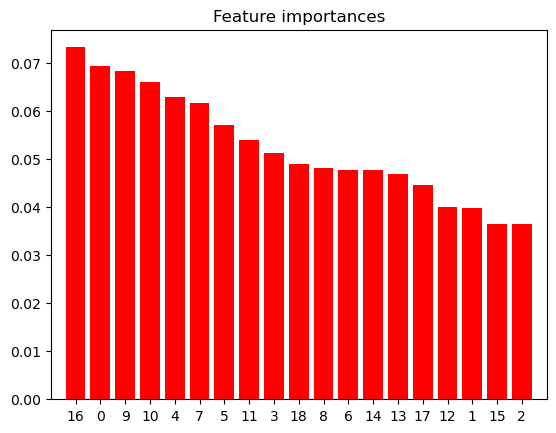

In [32]:
# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

This tells us which features are the most important, but not how these change our predictions. We can look at the form of the relationship between the occurrence of the pine and this feature (and any other one) using a partial dependency plot. This shows changes in the outcome across the range of some feature (with all other features effectively held constant). Here, we'll use the `PartialDependenceDisplay()` function from the the `inspection` submodule to produce the plot. As arguments, this requires the model, the DataFrame or array used to build the model, and the feature that you want to show. This will take an array of feature indices, allowing you to plot several dependency plots together. 

We'll start with the dependency for the most important feature (number 16 `bio17`; precipitation of driest quarter). Note that we use a particular function `from_estimator` to plot this from a model, together with the set of features and the index of the column we want to plot (refer to the printed list above to change this)

In [61]:
X_train.columns

Index(['bio1', 'bio2', 'bio3', 'bio4', 'bio5', 'bio6', 'bio7', 'bio8', 'bio9',
       'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17',
       'bio18', 'bio19'],
      dtype='object')

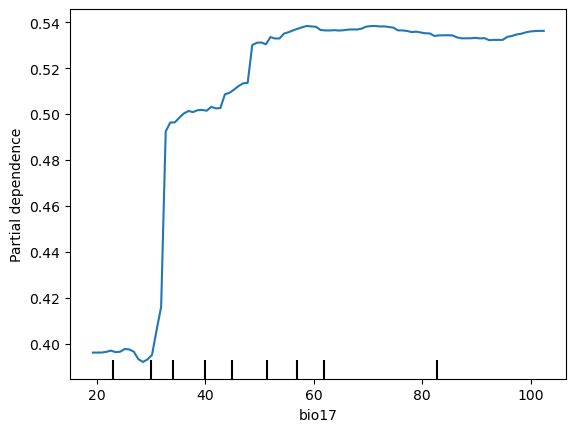

In [34]:
from sklearn.inspection import PartialDependenceDisplay

my_feature = 16
PartialDependenceDisplay.from_estimator(pe_rf_tuned.best_estimator_, X_train, ['bio17'])

This shows a clear threshold effect, with an abrupt drop in suitability as this drops below about 30. There is then a small increase up to about 50, and little further change at higher values. You can also plot multiple PDPs together: this will add the response to annual temperature changes (`bio1`), which has an optimum between values of about 6 and 10 degrees.

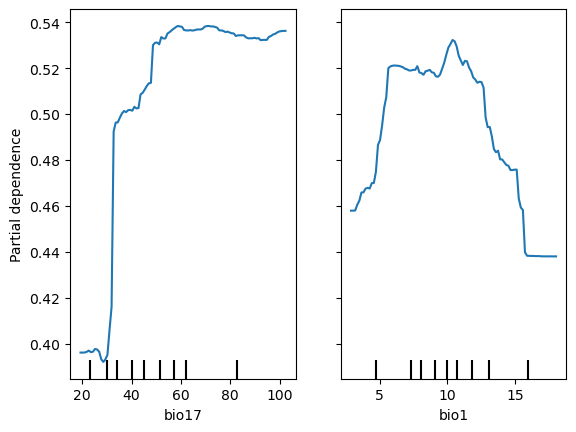

In [35]:
PartialDependenceDisplay.from_estimator(pe_rf_tuned.best_estimator_, X_train, ['bio17','bio1'])

## Boosted regression trees

We will now build a boosted regression tree model for the Pinus data. In contrast to random forests that build a set of individual weak trees, boosted regression trees (BRTs) start with a single weak tree and iteratively improve on this. This is done by targeting the residuals from the previous set of models and trying to model that in the next tree. While this can make these methods very powerful, it is easy for them to overfit the data, and hyperparameter tuning becomes very important here. 

We'll use the **scikit-learn** implementation of boosted regression here (`GradientBoostingClassifier`). As before, we'll start by simply running it with the default settings:

Note that an alternative is available through the **xgboost** library, which has a number of advantages with memory management and parallelization which can greatly speed up fitting these models. 

In [36]:
from sklearn.ensemble import GradientBoostingClassifier

pe_gbm = GradientBoostingClassifier()
pe_gbm.fit(X_train, y_train)
y_test_pred = pe_gbm.predict_proba(X_test)
roc_auc_score(y_test, y_test_pred[:,1])

np.float64(0.8894137260350097)

Now we'll try to tune it. First, get a list of available parameters

In [37]:
GradientBoostingClassifier().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Well, there's a lot. A thorough search strategy would probably include some of the following parameters:

1. `n_estimators`: Defines the number of boosting iterations (trees) to be added. More estimators usually lead to better performance, but also increase the risk of overfitting (default `100`)
2. `learning_rate`: Controls the contribution of each tree to the final prediction. A smaller value makes the model more robust but requires more estimators to achieve high performance (default `0.1`; each additional tree will have a 10% influence on the overall prediction)
3. `max_depth`: Specifies the maximum depth of each individual tree. Shallow trees might underfit while deeper trees can overfit. It's essential to find the right depth (default `None`)
4. `min_samples_split`: the minimum number of samples required to split an internal node. Increasing this value helps control overfitting by preventing the model from learning overly specific patterns (default `2`)
5. `subsample`: Specifies the fraction of samples to be used for fitting each individual tree (default `1.0`; all samples used in each tree, a lower number can reduce overfitting)
6. `colsample_bytree`: Defines the fraction of features to be randomly sampled for building each tree (default `1.0`; all features are used)
7. `min_samples_leaf`: Defines the minimum number of samples required to be at a terminal node, used for prediction (default 1; terminal nodes only need a single sample). Increasing this value can reduce overfitting
8. `max_features`: Specifies the number of features to consider when looking for the best split, similar to random forest (default `None`; all features are used)

In the interest of keeping this relatively fast, we'll just test the following parameters, each with a fairly coarse grid. In practice, you'd want to do this more exhaustively. 

- `learning_rate`: the contribution of each tree to the overall model (from 0.01 to 0.2 with a step of 0.01)
- `n_estimators`: the total number of trees built (100 to 400)
- `max_depth`: the number of splits in each tree (3 to 9 with a step of 2)

We also set the parameter `subsample` to 0.5 to only use a random selection of observations in building each tree. As this is a constant, it won't be varied during the grid search. Once this is setup, we'll run the usual cross-validated grid search. One final argument that we will use here is `n_jobs`. This will run the tuning in parallel by using multiple cpu cores. Setting this `n_jobs=-1` will use *all* available cores, which tuned the model in about 1.5 minutes on my laptop. 

In [38]:
gbm_param = {
    'learning_rate': np.arange(0.01, 0.2, 0.01), 
    'n_estimators': [100, 200, 300, 400],  
    'max_depth': [3, 5, 7, 9], 
    'subsample': [0.5] 
}

pe_gbm_tuned = GridSearchCV(GradientBoostingClassifier(), gbm_param, 
                             scoring='roc_auc', cv=5, verbose = 0, n_jobs=-1)
pe_gbm_tuned.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19]),
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [100, 200, 300, 400],
                         'subsample': [0.5]},
             scoring='roc_auc')

As before, we can examine the results, and calculate the AUC for the test set

In [39]:
print(pe_gbm_tuned.best_estimator_)

GradientBoostingClassifier(learning_rate=np.float64(0.04), max_depth=9,
                           n_estimators=200, subsample=0.5)


In [40]:
y_test_pred = pe_gbm_tuned.predict_proba(X_test)
roc_auc_score(y_test, y_test_pred[:,1])

np.float64(0.9227563212003334)

This is comparable, but a little lower than the tuned random forest. Further tuning of the boosted model may be worth investigating. 

We can again extract the variable importance scores from the tuned model, which again shows `bio17` as being the most importance feature. 

In [41]:
importances = pe_gbm_tuned.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], var_names[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature 16 bio17 (0.150048)
2. feature 7 bio8 (0.082519)
3. feature 11 bio12 (0.065178)
4. feature 0 bio1 (0.062979)
5. feature 14 bio15 (0.061854)
6. feature 4 bio5 (0.059299)
7. feature 1 bio2 (0.055010)
8. feature 9 bio10 (0.053788)
9. feature 6 bio7 (0.050317)
10. feature 18 bio19 (0.048030)
11. feature 17 bio18 (0.042592)
12. feature 3 bio4 (0.042467)
13. feature 5 bio6 (0.042463)
14. feature 10 bio11 (0.041689)
15. feature 8 bio9 (0.041337)
16. feature 12 bio13 (0.028451)
17. feature 2 bio3 (0.027672)
18. feature 13 bio14 (0.022675)
19. feature 15 bio16 (0.021633)


## Predictions

Now we tested and tuned our models, we can use them for prediction. For species distribution models, we generally want to predict the suitability for our species using a gridded dataset of the environmental variables used to build the model. The data are available in a NetCDF file called *current.env.nc*, which you should have downloaded. We can read this in (and work with it) using the **xarray** package:

In [42]:
import xarray as xr
curr_env = xr.open_dataset('./datafiles/current_env.nc')
curr_env.info

<bound method Dataset.info of <xarray.Dataset> Size: 26MB
Dimensions:    (longitude: 720, latitude: 480, z: 19)
Coordinates:
  * longitude  (longitude) float64 6kB -130.0 -129.9 -129.9 ... -100.1 -100.0
  * latitude   (latitude) float64 4kB 49.98 49.94 49.9 ... 30.1 30.06 30.02
  * z          (z) int32 76B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables:
    crs        int32 4B ...
    BIO        (z, latitude, longitude) float32 26MB ...
Attributes:
    Conventions:  CF-1.4
    created_by:   R, packages ncdf4 and raster (version 3.4-5)
    date:         2021-03-10 13:49:36>

We'll also load a shapefile of coastlines to help visualize these data and the predictions. These data are taken from Natural Earth, a free source of globally consistent map layers (https://www.naturalearthdata.com/)

<Axes: >

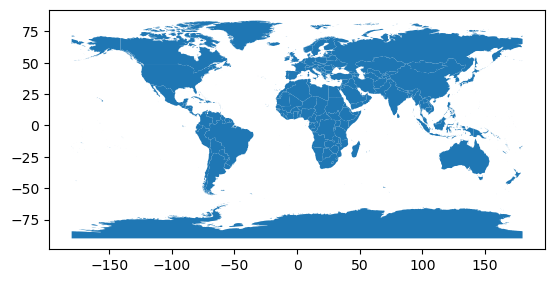

In [62]:
ne = gpd.read_file("./datafiles/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp")
ne.plot()

`xarray` introduces two new data objects to Python, a DataArray (which contain the variables we are interested in) and a DataSet, which is a collection of DataArrays. The `current_env` DataSet contains two DataArrays (`crs` and `BIO`). The second of these contains the bioclimate variables that we want to work with.

In [43]:
curr_env['BIO']

<xarray.DataArray 'BIO' (z: 19, latitude: 480, longitude: 720)> Size: 26MB
[6566400 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float64 6kB -130.0 -129.9 -129.9 ... -100.1 -100.0
  * latitude   (latitude) float64 4kB 49.98 49.94 49.9 ... 30.1 30.06 30.02
  * z          (z) int32 76B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Attributes:
    grid_mapping:  crs
    proj4:         +proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0
    min:           [ -7.1   5.6   2.4 165.9   6.  -24.1  11.8 -13.5 -15.3   0...
    max:           [  23.9   21.3    6.5 1299.2   45.6   10.    50.9   33.2  ...

You can plot any individual layer using the `plot()` method. Note the indexing used to identify the layer to be shown (`BIO[0]` = the first layer). This corresponds to `bio1` in the CSV file:

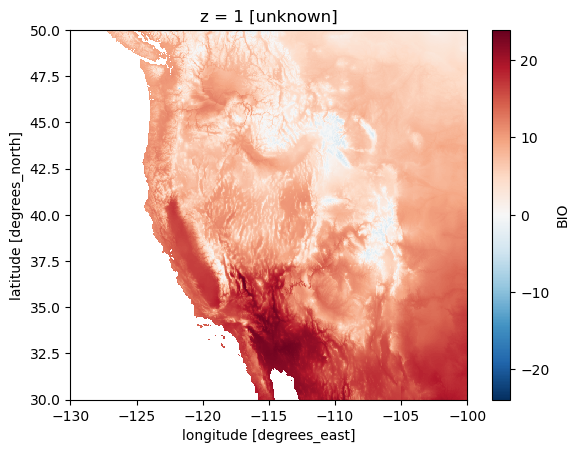

In [44]:
curr_env.BIO[0].plot()

We can also stack layers using **matplotlib**

<Axes: title={'center': 'z = 1 [unknown]'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

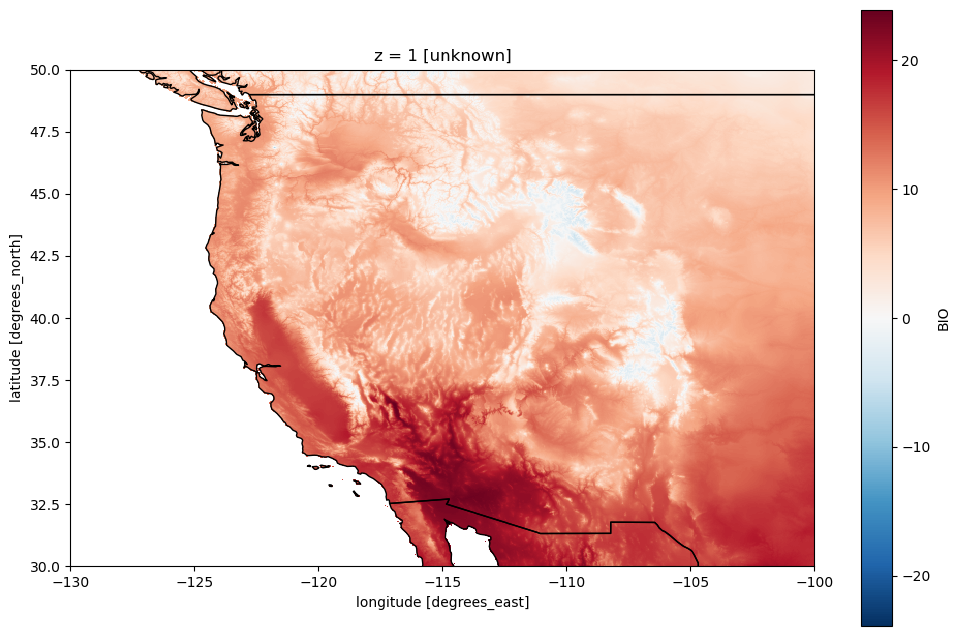

In [63]:
fig, ax = plt.subplots(figsize=(12, 8))
curr_env.BIO[0].plot(ax=ax) 
ne.plot(ax=ax, edgecolor='black', color='none') 

As the region we are using for our study area includes part of the Pacific Ocean, we'll create a land/sea mask. This will be used later to mask out any predictions over the ocean.  This is done quite simple by creating an array with 2's over the ocean (the NaN values in the data) and a second with 1's over the land. Then these are combined into the final mask.

<Axes: title={'center': 'z = 1 [unknown]'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

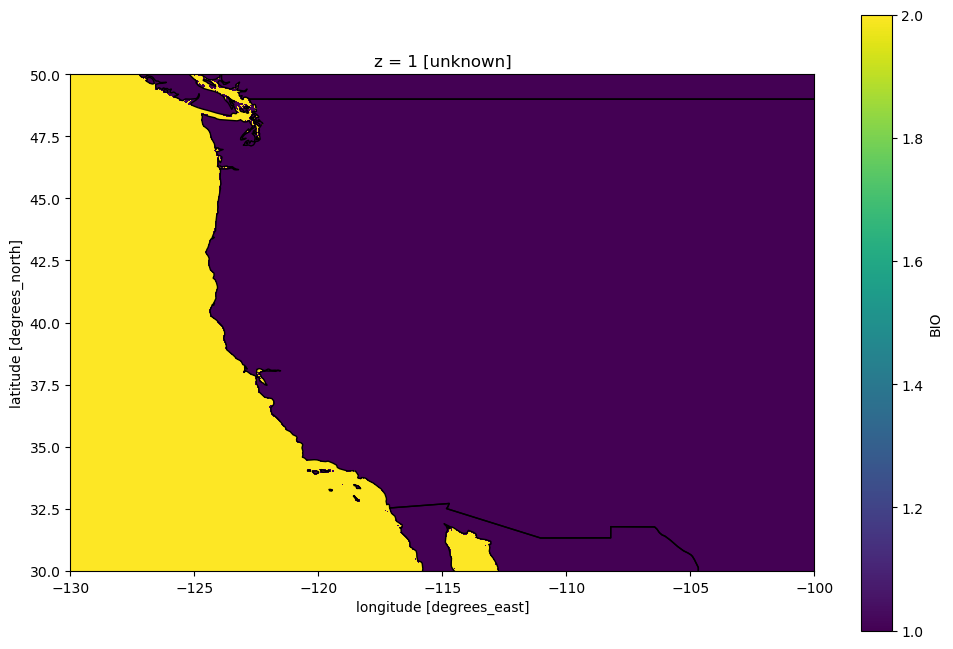

In [64]:
mask_ocean = 2 * np.ones((curr_env.sizes['latitude'], 
                          curr_env.sizes['longitude'])) * np.isnan(curr_env.BIO.isel(z=0))  
mask_land = 1 * np.ones((curr_env.sizes['latitude'], 
                         curr_env.sizes['longitude'])) * np.isfinite(curr_env.BIO.isel(z=0))  
mask_array = mask_ocean + mask_land

fig, ax = plt.subplots(figsize=(12, 8))
mask_array.plot(ax=ax) 
ne.plot(ax=ax, edgecolor='black', color='none') 

Unfortunately, we can't use the **xarray** directly for predictions. We'll need to convert it to a Pandas DataFrame. This requires a couple of steps. First, we use the `stack()` method to collapse the multiple levels into a 2D array, where the rows represent the variables and the columns represent individual grid locations:

In [46]:
bio_stack = curr_env.BIO.stack(dim = ['latitude', 'longitude'])
print(bio_stack.values)
print(bio_stack.shape)

[[  nan   nan   nan ...  18.2  18.2  17.9]
 [  nan   nan   nan ...  14.3  14.4  14.4]
 [  nan   nan   nan ...   4.2   4.2   4.2]
 ...
 [  nan   nan   nan ...  86.   87.   89. ]
 [  nan   nan   nan ... 204.  205.  208. ]
 [  nan   nan   nan ...  87.   87.   89. ]]
(19, 345600)


Now we create a DataFrame with the environmental variables. This needs to be transposed to have the same format as the DataFrame used in training the model

In [47]:
curr_env_df = pd.DataFrame(bio_stack.values.transpose(),
                columns = var_names)
curr_env_df

,bio1,bio2,bio3,bio4,bio5,bio6,bio7,bio8,bio9,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,bio18,bio19
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345595,18.100000,14.1,4.3,659.000000,33.500000,0.8,32.700001,23.000000,10.2,26.000000,9.1,625.0,81.0,22.0,39.0,216.0,82.0,201.0,84.0
345596,18.200001,14.2,4.2,668.299988,33.700001,0.6,33.099998,23.100000,10.1,26.200001,9.0,633.0,82.0,23.0,39.0,218.0,84.0,202.0,85.0
345597,18.200001,14.3,4.2,673.599976,33.799999,0.4,33.400002,23.100000,10.0,26.299999,9.0,638.0,82.0,24.0,39.0,220.0,86.0,204.0,87.0
345598,18.200001,14.4,4.2,680.200012,33.900002,0.3,33.599998,23.100000,10.0,26.400000,8.9,644.0,83.0,24.0,39.0,222.0,87.0,205.0,87.0


In [48]:
x = pe_rf_tuned.predict_proba(curr_env_df.fillna(0))
x.shape

(345600, 2)

In [49]:
curr_pred = xr.DataArray(x[:,1].reshape(480,720), 
                         coords=[curr_env.coords['latitude'], 
                                 curr_env.coords['longitude']])

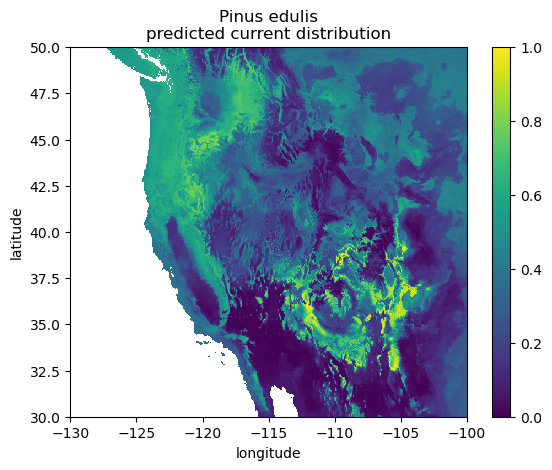

In [50]:
curr_pred.where(mask_array == 1).plot()
plt.title("Pinus edulis\npredicted current distribution")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

<Axes: title={'center': 'Pinus edulis\npredicted current distribution'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

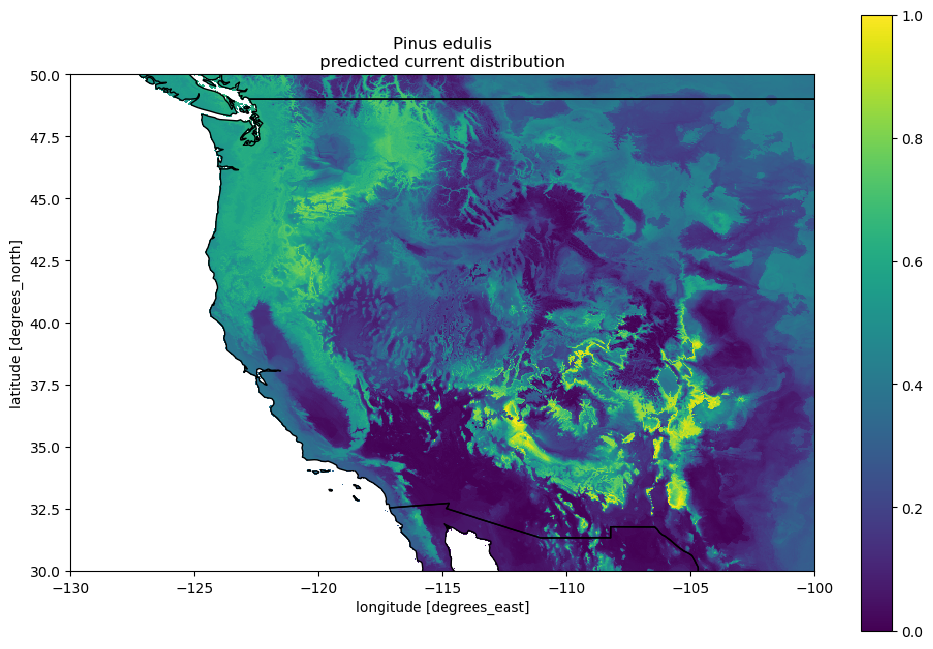

In [70]:
curr_pred = curr_pred.where(mask_array == 1)
fig, ax = plt.subplots(figsize=(12, 8))
curr_pred.plot(ax=ax) 
ax.set_title("Pinus edulis\npredicted current distribution")
ne.plot(ax=ax, edgecolor='black', color='none') 

This shows that model captures the current distribution well, but also predicts a large area of suitability in the north-west (suggesting that it is climatically suitable given the variables we've looked at). We can also plot the predicted presence/absence as a binary outcome. To do this, we first need to get the optimal threshold for discriminating between absence (0) and presence (1). The ROC curve (used to calculate the AUC) can be used to define this. First, let's calculate this (with `roc_curve`) and plot it. The plot is produced using the false positive rate on the x-axis (FPR; the number of 0's incorrectly predicted) and the true positive rate on the y-axis (TPR; the number of 1's correctly predicted)

Text(0, 0.5, 'True Positive Rate')

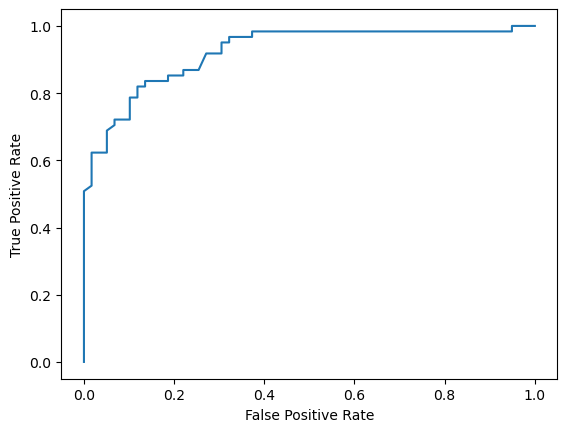

In [51]:
from sklearn.metrics import roc_curve

y_test_pred = pe_rf_tuned.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred[:,1])

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

The optimal threshold is found where the TPR is high and the FPR is low, so we can calculate this simply as the maximum difference between the two arrays: 

In [52]:
threshold_rf = thresholds[np.argmax(tpr - fpr)]
print(threshold_rf)

0.568


With this, we can now threshold the predicted probabilites to get a binary map of suitability:

<Axes: title={'center': 'Pinus edulis\npredicted current distribution'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

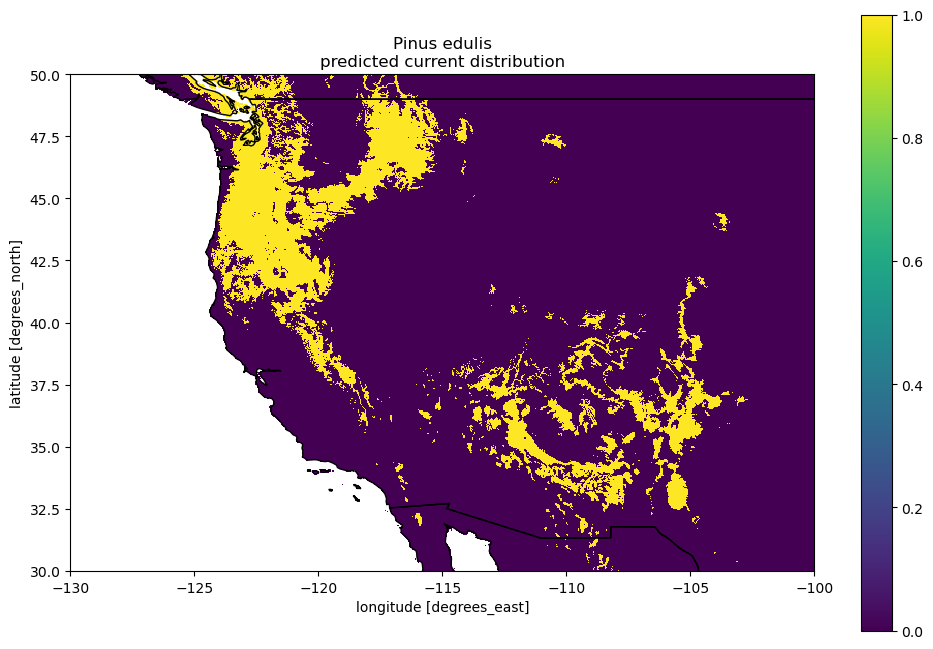

In [71]:
curr_pa = curr_pred > threshold_rf
curr_pa = curr_pa.where(mask_array == 1)

fig, ax = plt.subplots(figsize=(12, 8))
curr_pa.plot(ax=ax) 
ax.set_title("Pinus edulis\npredicted current distribution")
ne.plot(ax=ax, edgecolor='black', color='none') 


### Future climate

The previous maps are based on current (or at least end of last century) estimates of climate. We can equally predict for other time periods when we have data available. We also have the same data for the future (2080 under a high emissions climate scenario), so let's load that as well. We can go through the same steps to produce a map showing projected suitability for this species

In [54]:
future_env = xr.open_dataset('./datafiles/future_env.nc')
future_env.info

<bound method Dataset.info of <xarray.Dataset> Size: 26MB
Dimensions:    (longitude: 720, latitude: 480, z: 19)
Coordinates:
  * longitude  (longitude) float64 6kB -130.0 -129.9 -129.9 ... -100.1 -100.0
  * latitude   (latitude) float64 4kB 49.98 49.94 49.9 ... 30.1 30.06 30.02
  * z          (z) int32 76B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables:
    crs        int32 4B ...
    BIO        (z, latitude, longitude) float32 26MB ...
Attributes:
    Conventions:  CF-1.4
    created_by:   R, packages ncdf4 and raster (version 3.4-5)
    date:         2021-03-10 13:48:41>

In [55]:
bio_stack = future_env.BIO.stack(dim = ['latitude', 'longitude'])
future_env_df = pd.DataFrame(bio_stack.values.transpose(),
                columns = var_names)
future_crds = pd.DataFrame(bio_stack.dim.values)

x = pe_rf_tuned.predict_proba(future_env_df.fillna(0))
future_pred = xr.DataArray(x[:,1].reshape(480,720), 
                         coords=[future_env.coords['latitude'], 
                                 future_env.coords['longitude']])

<Axes: title={'center': 'Pinus edulis\npredicted future distribution'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

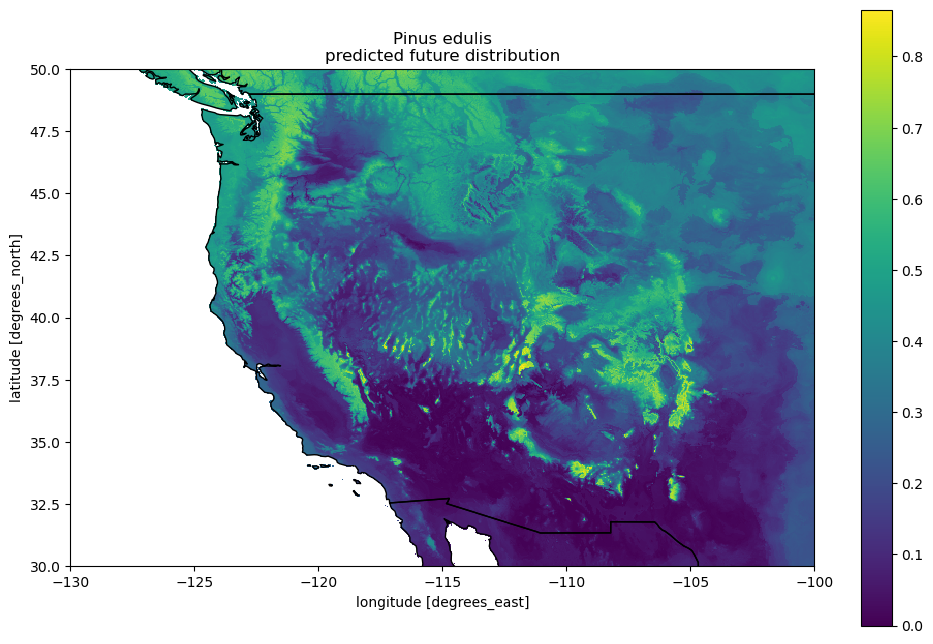

In [72]:
future_pred = future_pred.where(mask_array == 1)

fig, ax = plt.subplots(figsize=(12, 8))
future_pred.plot(ax=ax) 
ax.set_title("Pinus edulis\npredicted future distribution")
ne.plot(ax=ax, edgecolor='black', color='none') 


And again, we can use the threshold to identify areas of suitability.

<Axes: title={'center': 'Pinus edulis\npredicted future distribution'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

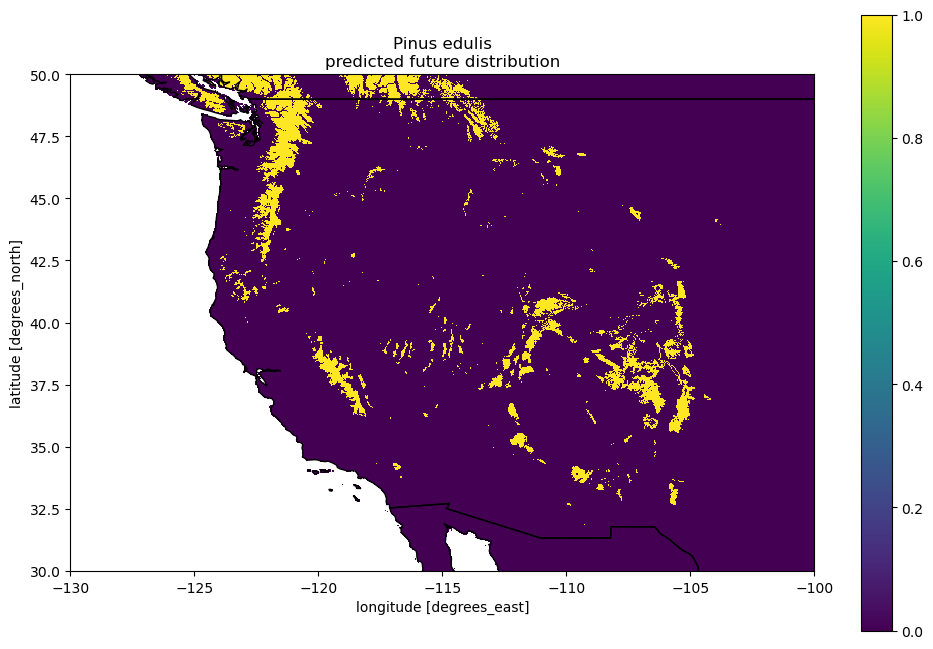

In [73]:
future_pa = future_pred > threshold_rf
future_pa = future_pa.where(mask_array == 1)
fig, ax = plt.subplots(figsize=(12, 8))
future_pa.plot(ax=ax) 
ax.set_title("Pinus edulis\npredicted future distribution")
ne.plot(ax=ax, edgecolor='black', color='none') 

As a final result, we can use the two binary maps to more easily visualize how the distribution of suitable areas is projected to change. By subtracting the current binary distribution from the future binary distribution, we end up with a map with three values:

- 1: new areas of suitability
- 0: No change
- -1: loss of suitability

/opt/homebrew/Caskroom/miniforge/base/envs/geog5160/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:213: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


<Axes: title={'center': 'Pinus edulis\npredicted change in distribution'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

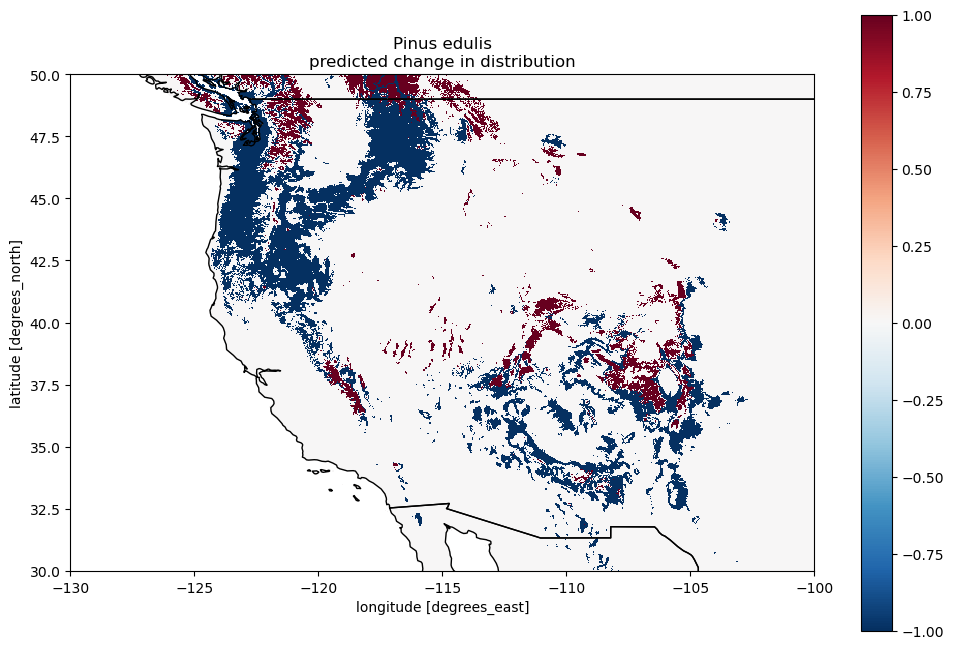

In [74]:
change_pa = future_pa.astype('int') - curr_pa.astype('int')
change_pa = change_pa.where(mask_array == 1)

fig, ax = plt.subplots(figsize=(12, 8))
change_pa.plot(ax=ax) 
ax.set_title("Pinus edulis\npredicted change in distribution")
ne.plot(ax=ax, edgecolor='black', color='none') 

## Exercise

Use a new notebook to record your answers and output. These should be submitted to Canvas by February 5th. Please use the following naming convention: `Lab02_lastname.ipynb`.

The goal of the exercise is to get you to build and evaluate the *area* of a house, rather than the price. A few things to note:

-   The `price` needs to be included as a feature
-   You still need to log-transform and encode variables
-   Your model should be evaluated using 4-fold cross-validation, and you should report the RMSE and $R^2$


## 6160 Students

In addition to the above exercise, you should build and evaluate a second logistic regression model for houses with high or low area.

-   Use a cutoff of 10,000 sq ft. (higher should be labeled as `high`)
-   Use 4-fold cross-validation
-   Report the accuracy, recall and specificity
-   Optional: why do you think there is such a large difference between recall and specificity in this model?

## Appendix

## Appendix 1: Bioclimate variables

- BIO1 = Annual Mean Temperature
- BIO2 = Mean Diurnal Range (Mean of monthly (max temp - min temp))
- BIO3 = Isothermality (BIO2/BIO7) (* 100)
- BIO4 = Temperature Seasonality (standard deviation *100)
- BIO5 = Max Temperature of Warmest Month
- BIO6 = Min Temperature of Coldest Month
- BIO7 = Temperature Annual Range (BIO5-BIO6)
- BIO8 = Mean Temperature of Wettest Quarter
- BIO9 = Mean Temperature of Driest Quarter
- BIO10 = Mean Temperature of Warmest Quarter
- BIO11 = Mean Temperature of Coldest Quarter
- BIO12 = Annual Precipitation
- BIO13 = Precipitation of Wettest Month
- BIO14 = Precipitation of Driest Month
- BIO15 = Precipitation Seasonality (Coefficient of Variation)
- BIO16 = Precipitation of Wettest Quarter
- BIO17 = Precipitation of Driest Quarter
- BIO18 = Precipitation of Warmest Quarter
- BIO19 = Precipitation of Coldest Quarter